# EXECUTIVE SUMMARY

> Predict whether a crime is completed or failed.

## PLANNING

We will use the PAPEM-DM framework for conducting this data science project. While we won't necessarily do the steps in order, we will iterate the notebook runs until we produce the best version of the notebook.

- [X] Planning
- [X] Acquire data
- [X] Prepare/pre-process the data
- [X] Exploratory data analysis
- [X] Modeling
- [X] Delivery
- [ ] ~~Maintenance~~

### Environment

Non-standard Python libraries used:
- matplotlib
- seaborn
- sklearn
- xgboost

In [1]:
# for manipulating dataframes
import pandas as pd
import numpy as np

# setting the random seed for reproducibility
import random
random.seed(493)
np.random.seed(493)

# for working with timestamps
from datetime import datetime
from dateutil.parser import parse

# for visualizations
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(12,6)})

# for modeling
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# to print out all the outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

# to suppress all warnings
import warnings
warnings.filterwarnings('ignore')

> Here, we are just defining functions that will be useful in EDA (Exploratory Data Analysis)

In [2]:
def get_values(df, columns):
    """
    Take a dataframe and a list of columns and
    returns the value counts for the columns.
    """
    for column in columns:
        print(column)
        print('===============================================')
        print(df[column].value_counts(dropna=False))
        print('\n')

def show_values(df, param):
    if param == 'all':
        get_values(df, df.columns)
    else:
        get_values(df, param)

In [3]:
def show_missing(df):
    """
    Takes a dataframe and returns a dataframe with stats
    on missing and null values with their percentages.
    """
    null_count = df.isnull().sum()
    null_percentage = (null_count / df.shape[0]) * 100
    empty_count = pd.Series(((df == ' ') | (df == '')).sum())
    empty_percentage = (empty_count / df.shape[0]) * 100
    nan_count = pd.Series(((df == 'nan') | (df == 'NaN')).sum())
    nan_percentage = (nan_count / df.shape[0]) * 100
    dfx = pd.DataFrame({'num_missing': null_count, 'missing_percentage': null_percentage,
                         'num_empty': empty_count, 'empty_percentage': empty_percentage,
                         'nan_count': nan_count, 'nan_percentage': nan_percentage})
    return dfx

## ACQUIRE THE DATA

The data used for this project can be found at the following link:
  
[New York City Crimes | Kaggle](https://www.kaggle.com/datasets/adamschroeder/crimes-new-york-city?select=NYPD_Complaint_Data_Historic.csv)

We're interested in two files. One contains the bulk of the data that we're going to use. We will also use "Crime_Column_Description.csv" to provide more context to the column names. The data contains reported crimes in NYC 2014-2015.

> We want only rows or records that are sex-related offences. Here, takes a look at the police description of the crime and looks for the word "SEX."

> Since, we've already run the block below and succesfully create a csv, we're going to comment this cell block to save processing time. Uncomment and run the cell below if this is the first time running the notebook.

In [4]:
# # Subset the data
# df = pd.read_csv('../data/NYPD_Complaint_Data_Historic.csv', encoding='utf-8')
# dfx = df[df['PD_DESC'].notna()]
# df1 = dfx.loc[dfx['PD_DESC'].str.contains("SEX")]
# df1.to_csv('../data/sex_related_offenses.csv', index=False)

In [5]:
# Get the data
df = pd.read_csv('data/sex_related_offenses.csv', parse_dates=True,  encoding='utf-8')

> Let's take a peek and get a feel of the data.

In [6]:
df.shape
df.info()
df.head()

(62608, 35)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62608 entries, 0 to 62607
Data columns (total 35 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CMPLNT_NUM         62608 non-null  int64  
 1   CMPLNT_FR_DT       62602 non-null  object 
 2   CMPLNT_FR_TM       62608 non-null  object 
 3   CMPLNT_TO_DT       46798 non-null  object 
 4   CMPLNT_TO_TM       46817 non-null  object 
 5   ADDR_PCT_CD        62600 non-null  float64
 6   RPT_DT             62608 non-null  object 
 7   KY_CD              62608 non-null  int64  
 8   OFNS_DESC          62598 non-null  object 
 9   PD_CD              62608 non-null  float64
 10  PD_DESC            62608 non-null  object 
 11  CRM_ATPT_CPTD_CD   62608 non-null  object 
 12  LAW_CAT_CD         62608 non-null  object 
 13  BORO_NM            62570 non-null  object 
 14  LOC_OF_OCCUR_DESC  47735 non-null  object 
 15  PREM_TYP_DESC      62179 non-null  object 
 16  JURIS_DESC         626

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,PD_DESC,CRM_ATPT_CPTD_CD,LAW_CAT_CD,BORO_NM,LOC_OF_OCCUR_DESC,PREM_TYP_DESC,JURIS_DESC,JURISDICTION_CODE,PARKS_NM,HADEVELOPT,HOUSING_PSA,X_COORD_CD,Y_COORD_CD,SUSP_AGE_GROUP,SUSP_RACE,SUSP_SEX,TRANSIT_DISTRICT,Latitude,Longitude,Lat_Lon,PATROL_BORO,STATION_NAME,VIC_AGE_GROUP,VIC_RACE,VIC_SEX
0,172284068,09/18/2018,18:30:00,09/18/2018,18:45:00,79.0,09/18/2018,233,SEX CRIMES,175.0,"SEXUAL ABUSE 3,2",COMPLETED,MISDEMEANOR,BROOKLYN,INSIDE,RESIDENCE - APT. HOUSE,N.Y. POLICE DEPT,0.0,NaN,NaN,NaN,999634.0,190253.0,25-44,BLACK,M,NaN,40.688872,-73.944529,"(40.688872153, -73.944529032)",PATROL BORO BKLYN NORTH,NaN,18-24,BLACK,F
1,633836360,07/02/2018,23:20:00,07/02/2018,23:40:00,30.0,07/03/2018,233,SEX CRIMES,175.0,"SEXUAL ABUSE 3,2",COMPLETED,MISDEMEANOR,MANHATTAN,FRONT OF,STREET,N.Y. POLICE DEPT,0.0,NaN,NaN,NaN,999794.0,241252.0,UNKNOWN,BLACK,M,NaN,40.828851,-73.943834,"(40.828851045, -73.943834191)",PATROL BORO MAN NORTH,NaN,18-24,WHITE,F
2,371642940,02/01/2017,08:00:00,NaN,NaN,120.0,10/26/2018,233,SEX CRIMES,170.0,"SEXUAL MISCONDUCT,INTERCOURSE",COMPLETED,MISDEMEANOR,STATEN ISLAND,INSIDE,RESIDENCE - APT. HOUSE,N.Y. POLICE DEPT,0.0,NaN,NaN,NaN,962748.0,174174.0,UNKNOWN,UNKNOWN,U,NaN,40.644726,-74.077483,"(40.644726131, -74.077483159)",PATROL BORO STATEN ISLAND,NaN,<18,BLACK,F
3,909559861,02/25/2018,00:01:00,02/25/2018,20:00:00,17.0,02/26/2018,233,SEX CRIMES,175.0,"SEXUAL ABUSE 3,2",COMPLETED,MISDEMEANOR,MANHATTAN,NaN,TRANSIT - NYC SUBWAY,N.Y. TRANSIT POLICE,1.0,NaN,NaN,NaN,992411.0,215025.0,NaN,NaN,NaN,4.0,40.756875,-73.970544,"(40.756874911, -73.970544057)",PATROL BORO MAN SOUTH,LEXINGTON AVE.,45-64,BLACK,M
4,100085475,03/01/2018,08:47:00,03/01/2018,09:07:00,13.0,03/01/2018,233,SEX CRIMES,175.0,"SEXUAL ABUSE 3,2",COMPLETED,MISDEMEANOR,MANHATTAN,NaN,TRANSIT - NYC SUBWAY,N.Y. TRANSIT POLICE,1.0,NaN,NaN,NaN,988874.0,207673.0,18-24,BLACK,M,4.0,40.736698,-73.983316,"(40.73669807, -73.983316026)",PATROL BORO MAN SOUTH,14 STREET,25-44,ASIAN / PACIFIC ISLANDER,F


## PREPARE/PRE-PROCESS

Let's do some data wrangling to prepare our dataset for EDA and modeling.

> Let's drop some columns.

In [7]:
columns_to_drop = ['CMPLNT_NUM', 'CMPLNT_TO_DT', 'CMPLNT_TO_TM',
                   'OFNS_DESC', 'PD_DESC', 'LOC_OF_OCCUR_DESC',
                   'PREM_TYP_DESC', 'JURIS_DESC', 'X_COORD_CD',
                   'Y_COORD_CD', 'Latitude', 'Longitude',
                   'Lat_Lon', 'PATROL_BORO', 'STATION_NAME'
                  ]

In [8]:
# Drop for the columns
df1 = df.drop(columns_to_drop, axis=1)

In [9]:
df1.shape

(62608, 20)

In [10]:
df1.columns

Index(['CMPLNT_FR_DT', 'CMPLNT_FR_TM', 'ADDR_PCT_CD', 'RPT_DT', 'KY_CD',
       'PD_CD', 'CRM_ATPT_CPTD_CD', 'LAW_CAT_CD', 'BORO_NM',
       'JURISDICTION_CODE', 'PARKS_NM', 'HADEVELOPT', 'HOUSING_PSA',
       'SUSP_AGE_GROUP', 'SUSP_RACE', 'SUSP_SEX', 'TRANSIT_DISTRICT',
       'VIC_AGE_GROUP', 'VIC_RACE', 'VIC_SEX'],
      dtype='object')

> Let's rename the remaining columns for readability and clarity.

In [11]:
# Rename the columns
df1.rename(columns={'CMPLNT_FR_DT':'complaint_date',
                    'CMPLNT_FR_TM':'complaint_time',
                    'ADDR_PCT_CD':'precinct',
                    'RPT_DT':'date_reported',
                    'KY_CD':'offense_code',
                    'PD_CD':'offense_code_internal',
                    'CRM_ATPT_CPTD_CD':'target',
                    'LAW_CAT_CD':'level_offense',
                    'BORO_NM':'borough',
                    'JURISDICTION_CODE':'jurisdiction',
                    'PARKS_NM':'nyc_place',
                    'HADEVELOPT':'housing_development',
                    'HOUSING_PSA':'housing_development_level',
                    'SUSP_AGE_GROUP':'suspect_age',
                    'SUSP_RACE':'suspect_race',
                    'SUSP_SEX':'suspect_sex',
                    'TRANSIT_DISTRICT':'transit_district',
                    'VIC_AGE_GROUP':'victim_age',
                    'VIC_RACE':'victim_race',
                    'VIC_SEX':'victim_sex'
                   }, inplace=True)

In [12]:
df1.head().T

,0,1,2,3,4
complaint_date,09/18/2018,07/02/2018,02/01/2017,02/25/2018,03/01/2018
complaint_time,18:30:00,23:20:00,08:00:00,00:01:00,08:47:00
precinct,79.0,30.0,120.0,17.0,13.0
date_reported,09/18/2018,07/03/2018,10/26/2018,02/26/2018,03/01/2018
offense_code,233,233,233,233,233
offense_code_internal,175.0,175.0,170.0,175.0,175.0
target,COMPLETED,COMPLETED,COMPLETED,COMPLETED,COMPLETED
level_offense,MISDEMEANOR,MISDEMEANOR,MISDEMEANOR,MISDEMEANOR,MISDEMEANOR
borough,BROOKLYN,MANHATTAN,STATEN ISLAND,MANHATTAN,MANHATTAN
jurisdiction,0.0,0.0,0.0,1.0,1.0


> Let's look for some missing values.

In [13]:
show_missing(df1)

,num_missing,missing_percentage,num_empty,empty_percentage,nan_count,nan_percentage
complaint_date,6,0.009583,0,0.0,0,0.0
complaint_time,0,0.000000,0,0.0,0,0.0
precinct,8,0.012778,0,0.0,0,0.0
date_reported,0,0.000000,0,0.0,0,0.0
offense_code,0,0.000000,0,0.0,0,0.0
offense_code_internal,0,0.000000,0,0.0,0,0.0
target,0,0.000000,0,0.0,0,0.0
level_offense,0,0.000000,0,0.0,0,0.0
borough,38,0.060695,0,0.0,0,0.0
jurisdiction,0,0.000000,0,0.0,0,0.0


> Let's remove the rows with null values on them for a number of columns that only has a few missing values.

> Note, that the code in the cell block below is repetitive. We can refactor this later.

In [14]:
# Remove rows with null values
df1 = df1.loc[df1['complaint_date'].notnull()]
df1 = df1.loc[df1['precinct'].notnull()]
df1 = df1.loc[df1['borough'].notnull()]
df1 = df1.loc[df1['victim_age'].notnull()]
df1 = df1.loc[df1['victim_race'].notnull()]
df1 = df1.loc[df1['victim_sex'].notnull()]
df1.shape

(60664, 20)

In [15]:
show_missing(df1)

,num_missing,missing_percentage,num_empty,empty_percentage,nan_count,nan_percentage
complaint_date,0,0.000000,0,0.0,0,0.0
complaint_time,0,0.000000,0,0.0,0,0.0
precinct,0,0.000000,0,0.0,0,0.0
date_reported,0,0.000000,0,0.0,0,0.0
offense_code,0,0.000000,0,0.0,0,0.0
offense_code_internal,0,0.000000,0,0.0,0,0.0
target,0,0.000000,0,0.0,0,0.0
level_offense,0,0.000000,0,0.0,0,0.0
borough,0,0.000000,0,0.0,0,0.0
jurisdiction,0,0.000000,0,0.0,0,0.0


> Let's completely remove the columns with a significant number of null values.

> But before we do, let's make a copy of the dataframe since removing columns means losing a lot of datapoints that we could possibly use later for EDA.

In [16]:
df1_copy = df1.copy() # remember this for EDA

> Now, we're ready.

In [17]:
# Drop columns
df1 = df1.drop(['nyc_place', 'housing_development', 'housing_development_level', 'suspect_age', 'suspect_race', 'suspect_sex', 'transit_district'], axis=1)

In [18]:
df1.shape

(60664, 13)

In [19]:
df1.head()

,complaint_date,complaint_time,precinct,date_reported,offense_code,offense_code_internal,target,level_offense,borough,jurisdiction,victim_age,victim_race,victim_sex
0,09/18/2018,18:30:00,79.0,09/18/2018,233,175.0,COMPLETED,MISDEMEANOR,BROOKLYN,0.0,18-24,BLACK,F
1,07/02/2018,23:20:00,30.0,07/03/2018,233,175.0,COMPLETED,MISDEMEANOR,MANHATTAN,0.0,18-24,WHITE,F
2,02/01/2017,08:00:00,120.0,10/26/2018,233,170.0,COMPLETED,MISDEMEANOR,STATEN ISLAND,0.0,<18,BLACK,F
3,02/25/2018,00:01:00,17.0,02/26/2018,233,175.0,COMPLETED,MISDEMEANOR,MANHATTAN,1.0,45-64,BLACK,M
4,03/01/2018,08:47:00,13.0,03/01/2018,233,175.0,COMPLETED,MISDEMEANOR,MANHATTAN,1.0,25-44,ASIAN / PACIFIC ISLANDER,F


In [20]:
show_values(df1, ['offense_code',
                  'offense_code_internal',
                  'level_offense',
                  'borough',
                  'jurisdiction',
                  'victim_age',
                  'victim_race',
                  'victim_sex',
                  'target'
                 ])

offense_code
233    50068
116    10090
126      380
115      120
361        5
578        1
Name: offense_code, dtype: int64


offense_code_internal
175.0    44896
177.0     5192
170.0     4819
179.0     4258
180.0      455
174.0      345
696.0      322
176.0      158
586.0      120
697.0       58
100.0       33
646.0        5
178.0        3
Name: offense_code_internal, dtype: int64


level_offense
MISDEMEANOR    50065
FELONY         10599
Name: level_offense, dtype: int64


borough
BROOKLYN         18700
MANHATTAN        17368
QUEENS           11647
BRONX            10887
STATEN ISLAND     2062
Name: borough, dtype: int64


jurisdiction
0.0     48837
1.0      6588
2.0      4565
3.0       188
97.0      154
72.0      144
14.0       85
69.0       39
88.0       20
13.0       10
6.0         9
11.0        8
15.0        5
12.0        5
9.0         3
7.0         2
4.0         1
76.0        1
Name: jurisdiction, dtype: int64


victim_age
<18        26317
25-44      16976
18-24      11591
45-64 

In [21]:
df2 = df1.copy()

In [22]:
df2.shape

(60664, 13)

> Below, we can see that our dataset is imbalanced. We'll fix that later!

In [23]:
show_values(df2, ['target'])

target
COMPLETED    59310
ATTEMPTED     1354
Name: target, dtype: int64




In [24]:
df2.head().T

,0,1,2,3,4
complaint_date,09/18/2018,07/02/2018,02/01/2017,02/25/2018,03/01/2018
complaint_time,18:30:00,23:20:00,08:00:00,00:01:00,08:47:00
precinct,79.0,30.0,120.0,17.0,13.0
date_reported,09/18/2018,07/03/2018,10/26/2018,02/26/2018,03/01/2018
offense_code,233,233,233,233,233
offense_code_internal,175.0,175.0,170.0,175.0,175.0
target,COMPLETED,COMPLETED,COMPLETED,COMPLETED,COMPLETED
level_offense,MISDEMEANOR,MISDEMEANOR,MISDEMEANOR,MISDEMEANOR,MISDEMEANOR
borough,BROOKLYN,MANHATTAN,STATEN ISLAND,MANHATTAN,MANHATTAN
jurisdiction,0.0,0.0,0.0,1.0,1.0


> Let's modify the data type for the complaint_date column.

In [25]:
df2["complaint_date"] = pd.to_datetime(df2["complaint_date"], errors = 'coerce')

In [26]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60664 entries, 0 to 62607
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   complaint_date         60660 non-null  datetime64[ns]
 1   complaint_time         60664 non-null  object        
 2   precinct               60664 non-null  float64       
 3   date_reported          60664 non-null  object        
 4   offense_code           60664 non-null  int64         
 5   offense_code_internal  60664 non-null  float64       
 6   target                 60664 non-null  object        
 7   level_offense          60664 non-null  object        
 8   borough                60664 non-null  object        
 9   jurisdiction           60664 non-null  float64       
 10  victim_age             60664 non-null  object        
 11  victim_race            60664 non-null  object        
 12  victim_sex             60664 non-null  object        
dtypes

In [27]:
df2.head()

,complaint_date,complaint_time,precinct,date_reported,offense_code,offense_code_internal,target,level_offense,borough,jurisdiction,victim_age,victim_race,victim_sex
0,2018-09-18,18:30:00,79.0,09/18/2018,233,175.0,COMPLETED,MISDEMEANOR,BROOKLYN,0.0,18-24,BLACK,F
1,2018-07-02,23:20:00,30.0,07/03/2018,233,175.0,COMPLETED,MISDEMEANOR,MANHATTAN,0.0,18-24,WHITE,F
2,2017-02-01,08:00:00,120.0,10/26/2018,233,170.0,COMPLETED,MISDEMEANOR,STATEN ISLAND,0.0,<18,BLACK,F
3,2018-02-25,00:01:00,17.0,02/26/2018,233,175.0,COMPLETED,MISDEMEANOR,MANHATTAN,1.0,45-64,BLACK,M
4,2018-03-01,08:47:00,13.0,03/01/2018,233,175.0,COMPLETED,MISDEMEANOR,MANHATTAN,1.0,25-44,ASIAN / PACIFIC ISLANDER,F


> Let's do a little bit of feature engineering by creating a column that identifies where the complaint_date occurs on a weekend or not.

> Let's start by converting the dates into its corresponding week number.
>- 0 = Monday
>- 1 = Tuesday
>- 2 = Wedday
>- 3 = Thursday
>- 4 = Friday
>- 5 = Saturday
>- 6 = Sunday

In [28]:
# Create a column based on the value of the complaint_date column
df2['weekday'] = df2['complaint_date'].dt.weekday

In [29]:
df2.head()

,complaint_date,complaint_time,precinct,date_reported,offense_code,offense_code_internal,target,level_offense,borough,jurisdiction,victim_age,victim_race,victim_sex,weekday
0,2018-09-18,18:30:00,79.0,09/18/2018,233,175.0,COMPLETED,MISDEMEANOR,BROOKLYN,0.0,18-24,BLACK,F,1.0
1,2018-07-02,23:20:00,30.0,07/03/2018,233,175.0,COMPLETED,MISDEMEANOR,MANHATTAN,0.0,18-24,WHITE,F,0.0
2,2017-02-01,08:00:00,120.0,10/26/2018,233,170.0,COMPLETED,MISDEMEANOR,STATEN ISLAND,0.0,<18,BLACK,F,2.0
3,2018-02-25,00:01:00,17.0,02/26/2018,233,175.0,COMPLETED,MISDEMEANOR,MANHATTAN,1.0,45-64,BLACK,M,6.0
4,2018-03-01,08:47:00,13.0,03/01/2018,233,175.0,COMPLETED,MISDEMEANOR,MANHATTAN,1.0,25-44,ASIAN / PACIFIC ISLANDER,F,3.0


> Then, let's create the weekend column that signals whether it's a weekend or not.

In [30]:
# Create a new column based on whether weekday is a weekend or not.
df2["weekend"] = np.where(df2['weekday'] > 3, 1, 0)

# Let's drop the columns that we don't need anymore
df2 = df2.drop(['weekday', 'complaint_date', 'complaint_time', 'date_reported'], axis=1)
df2.head()

,precinct,offense_code,offense_code_internal,target,level_offense,borough,jurisdiction,victim_age,victim_race,victim_sex,weekend
0,79.0,233,175.0,COMPLETED,MISDEMEANOR,BROOKLYN,0.0,18-24,BLACK,F,0
1,30.0,233,175.0,COMPLETED,MISDEMEANOR,MANHATTAN,0.0,18-24,WHITE,F,0
2,120.0,233,170.0,COMPLETED,MISDEMEANOR,STATEN ISLAND,0.0,<18,BLACK,F,0
3,17.0,233,175.0,COMPLETED,MISDEMEANOR,MANHATTAN,1.0,45-64,BLACK,M,1
4,13.0,233,175.0,COMPLETED,MISDEMEANOR,MANHATTAN,1.0,25-44,ASIAN / PACIFIC ISLANDER,F,0


> Let's correct the rest of the variables with the wrong dtype.

In [31]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60664 entries, 0 to 62607
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   precinct               60664 non-null  float64
 1   offense_code           60664 non-null  int64  
 2   offense_code_internal  60664 non-null  float64
 3   target                 60664 non-null  object 
 4   level_offense          60664 non-null  object 
 5   borough                60664 non-null  object 
 6   jurisdiction           60664 non-null  float64
 7   victim_age             60664 non-null  object 
 8   victim_race            60664 non-null  object 
 9   victim_sex             60664 non-null  object 
 10  weekend                60664 non-null  int32  
dtypes: float64(3), int32(1), int64(1), object(6)
memory usage: 5.3+ MB


In [32]:
# Using DataFrame.astype() function
df2["precinct"] = df2["precinct"].astype('str')
df2["offense_code"] = df2["offense_code"].astype('str')
df2["offense_code_internal"] = df2["offense_code_internal"].astype('str')
df2["jurisdiction"] = df2["jurisdiction"].astype('str')

In [33]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60664 entries, 0 to 62607
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   precinct               60664 non-null  object
 1   offense_code           60664 non-null  object
 2   offense_code_internal  60664 non-null  object
 3   target                 60664 non-null  object
 4   level_offense          60664 non-null  object
 5   borough                60664 non-null  object
 6   jurisdiction           60664 non-null  object
 7   victim_age             60664 non-null  object
 8   victim_race            60664 non-null  object
 9   victim_sex             60664 non-null  object
 10  weekend                60664 non-null  int32 
dtypes: int32(1), object(10)
memory usage: 5.3+ MB


> Let's convert the target from categorical to to numerical data type to make our dataset more suitable for machine learning.

In [34]:
# Create new column based on the value of target.
df2['class'] = np.where(df2['target'] == 'COMPLETED', 1, 0)

# Drop unncessary columns
df2 = df2.drop(['target'], axis=1)
df2.head()

,precinct,offense_code,offense_code_internal,level_offense,borough,jurisdiction,victim_age,victim_race,victim_sex,weekend,class
0,79.0,233,175.0,MISDEMEANOR,BROOKLYN,0.0,18-24,BLACK,F,0,1
1,30.0,233,175.0,MISDEMEANOR,MANHATTAN,0.0,18-24,WHITE,F,0,1
2,120.0,233,170.0,MISDEMEANOR,STATEN ISLAND,0.0,<18,BLACK,F,0,1
3,17.0,233,175.0,MISDEMEANOR,MANHATTAN,1.0,45-64,BLACK,M,1,1
4,13.0,233,175.0,MISDEMEANOR,MANHATTAN,1.0,25-44,ASIAN / PACIFIC ISLANDER,F,0,1


In [35]:
show_values(df2, ['level_offense', 'borough', 'victim_age', 'victim_race', 'victim_sex'])

level_offense
MISDEMEANOR    50065
FELONY         10599
Name: level_offense, dtype: int64


borough
BROOKLYN         18700
MANHATTAN        17368
QUEENS           11647
BRONX            10887
STATEN ISLAND     2062
Name: borough, dtype: int64


victim_age
<18        26317
25-44      16976
18-24      11591
45-64       3888
UNKNOWN     1361
65+          531
Name: victim_age, dtype: int64


victim_race
BLACK                             18338
WHITE HISPANIC                    17981
WHITE                             12069
UNKNOWN                            4563
ASIAN / PACIFIC ISLANDER           4189
BLACK HISPANIC                     3363
AMERICAN INDIAN/ALASKAN NATIVE      159
OTHER                                 2
Name: victim_race, dtype: int64


victim_sex
F    55276
M     5057
E      329
D        2
Name: victim_sex, dtype: int64




> victim_age's data type is numerical. Let's change that to categorical.

In [36]:
# Replace based on the value of victim_age.
df2['victim_age'] = df2['victim_age'].replace('<18', 'UNDER 18')
df2['victim_age'] = df2['victim_age'].replace('25-44', '25 TO 44')
df2['victim_age'] = df2['victim_age'].replace('18-24', '18 TO 24')
df2['victim_age'] = df2['victim_age'].replace('45-64', '45 TO 64')
df2['victim_age'] = df2['victim_age'].replace('65+', '65 AND OLDER')

In [37]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60664 entries, 0 to 62607
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   precinct               60664 non-null  object
 1   offense_code           60664 non-null  object
 2   offense_code_internal  60664 non-null  object
 3   level_offense          60664 non-null  object
 4   borough                60664 non-null  object
 5   jurisdiction           60664 non-null  object
 6   victim_age             60664 non-null  object
 7   victim_race            60664 non-null  object
 8   victim_sex             60664 non-null  object
 9   weekend                60664 non-null  int32 
 10  class                  60664 non-null  int32 
dtypes: int32(2), object(9)
memory usage: 5.1+ MB


In [38]:
df2.head()

,precinct,offense_code,offense_code_internal,level_offense,borough,jurisdiction,victim_age,victim_race,victim_sex,weekend,class
0,79.0,233,175.0,MISDEMEANOR,BROOKLYN,0.0,18 TO 24,BLACK,F,0,1
1,30.0,233,175.0,MISDEMEANOR,MANHATTAN,0.0,18 TO 24,WHITE,F,0,1
2,120.0,233,170.0,MISDEMEANOR,STATEN ISLAND,0.0,UNDER 18,BLACK,F,0,1
3,17.0,233,175.0,MISDEMEANOR,MANHATTAN,1.0,45 TO 64,BLACK,M,1,1
4,13.0,233,175.0,MISDEMEANOR,MANHATTAN,1.0,25 TO 44,ASIAN / PACIFIC ISLANDER,F,0,1


In [39]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60664 entries, 0 to 62607
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   precinct               60664 non-null  object
 1   offense_code           60664 non-null  object
 2   offense_code_internal  60664 non-null  object
 3   level_offense          60664 non-null  object
 4   borough                60664 non-null  object
 5   jurisdiction           60664 non-null  object
 6   victim_age             60664 non-null  object
 7   victim_race            60664 non-null  object
 8   victim_sex             60664 non-null  object
 9   weekend                60664 non-null  int32 
 10  class                  60664 non-null  int32 
dtypes: int32(2), object(9)
memory usage: 5.1+ MB


In [40]:
df3 = df2.copy() # remember this for EDA

## EXPLORATORY DATA ANALYSIS

For this part, we will explore the dataset and attempt to uncover some insights.

> Let's retrieve the dataframe that we created earlier before we remove a lot of columns.

In [41]:
df3.shape
df3.info()
df3.describe()

(60664, 11)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60664 entries, 0 to 62607
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   precinct               60664 non-null  object
 1   offense_code           60664 non-null  object
 2   offense_code_internal  60664 non-null  object
 3   level_offense          60664 non-null  object
 4   borough                60664 non-null  object
 5   jurisdiction           60664 non-null  object
 6   victim_age             60664 non-null  object
 7   victim_race            60664 non-null  object
 8   victim_sex             60664 non-null  object
 9   weekend                60664 non-null  int32 
 10  class                  60664 non-null  int32 
dtypes: int32(2), object(9)
memory usage: 5.1+ MB


,weekend,class
count,60664.000000,60664.000000
mean,0.419985,0.977680
std,0.493560,0.147722
min,0.000000,0.000000
25%,0.000000,1.000000
50%,0.000000,1.000000
75%,1.000000,1.000000
max,1.000000,1.000000


In [42]:
show_values(df3, 'all')

precinct
14.0     2612
75.0     1982
13.0     1628
115.0    1400
44.0     1238
73.0     1235
110.0    1230
43.0     1184
114.0    1172
40.0     1170
18.0     1150
83.0     1145
67.0     1134
52.0     1084
46.0     1076
19.0     1057
77.0     1049
70.0     1043
120.0    1035
47.0      986
79.0      980
41.0      968
72.0      955
108.0     933
25.0      904
66.0      875
109.0     875
71.0      871
48.0      851
42.0      821
103.0     787
60.0      787
17.0      785
90.0      781
23.0      772
62.0      766
81.0      755
5.0       746
1.0       739
32.0      723
9.0       718
102.0     716
105.0     695
49.0      683
20.0      677
104.0     653
113.0     642
34.0      635
61.0      632
107.0     630
84.0      601
6.0       593
69.0      563
24.0      551
10.0      537
33.0      534
122.0     525
106.0     518
30.0      506
68.0      501
28.0      493
101.0     491
88.0      476
7.0       465
78.0      458
63.0      456
26.0      439
45.0      437
112.0     436
50.0      387
94.0      3

<Axes: xlabel='count', ylabel='precinct'>

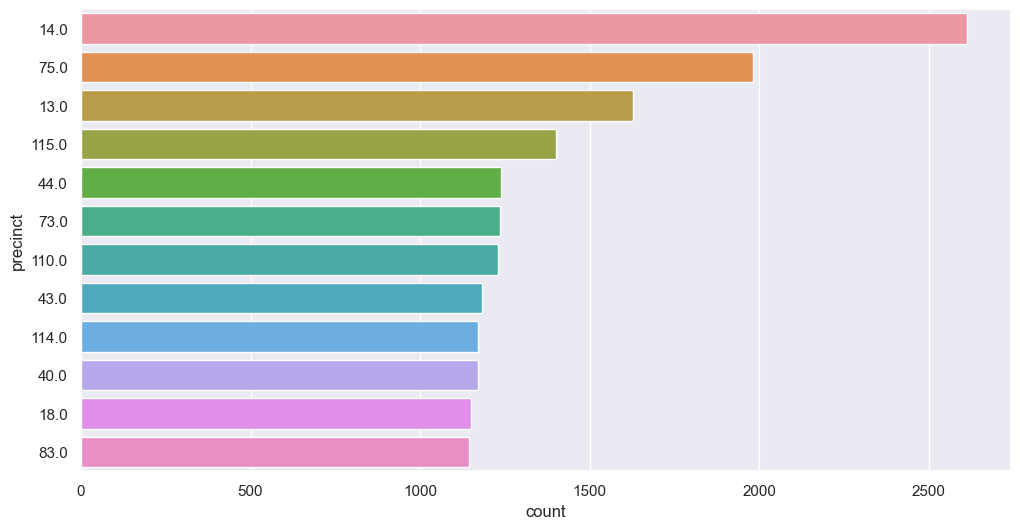

In [43]:
sns.countplot(y="precinct", data=df3,
              order=df3.precinct.value_counts().iloc[:12].index)

> The chart above shows Precinct 14 have the most crimes. Precinct 75 and 13 come in second and third respectively.

<Axes: xlabel='count', ylabel='offense_code'>

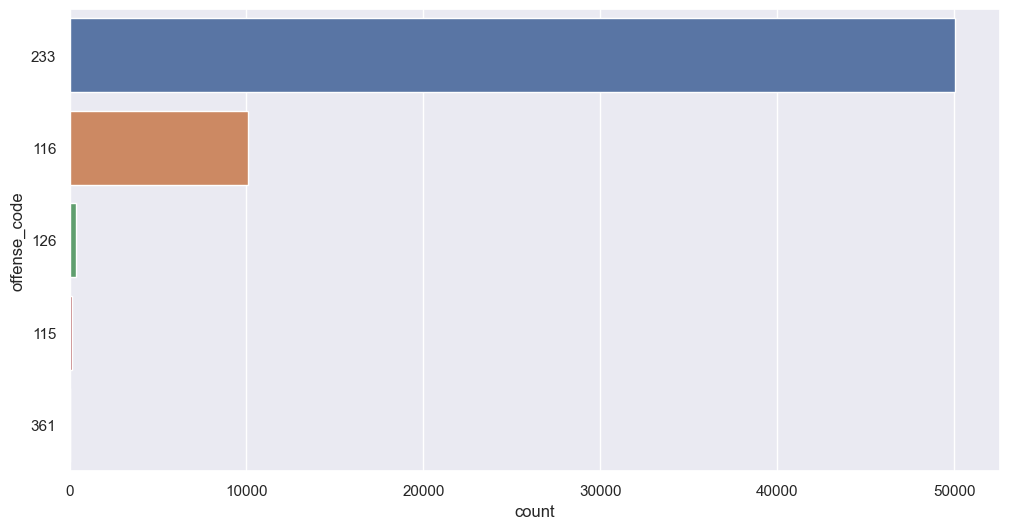

In [44]:
sns.countplot(y="offense_code", data=df3,
              order=df3.offense_code.value_counts().iloc[:5].index)

> The chart above shows Offense Code# 233 as the most perpetrated crime in New York City.

<Axes: xlabel='count', ylabel='level_offense'>

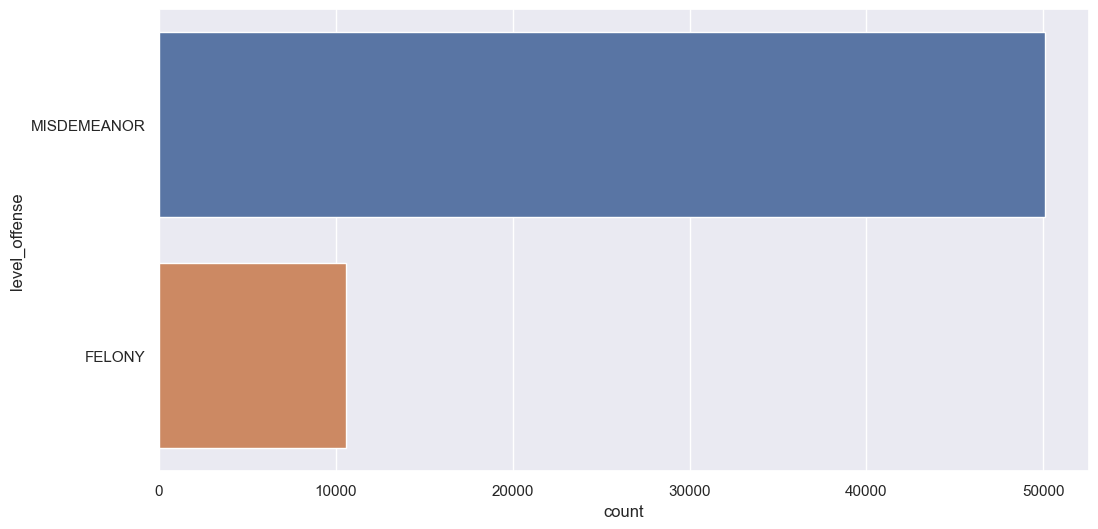

In [45]:
sns.countplot(y="level_offense", data=df3,
              order=df3.level_offense.value_counts().iloc[:2].index)

> The chart above compares the number of misdemeanors versus felonies.

<Axes: xlabel='count', ylabel='level_offense'>

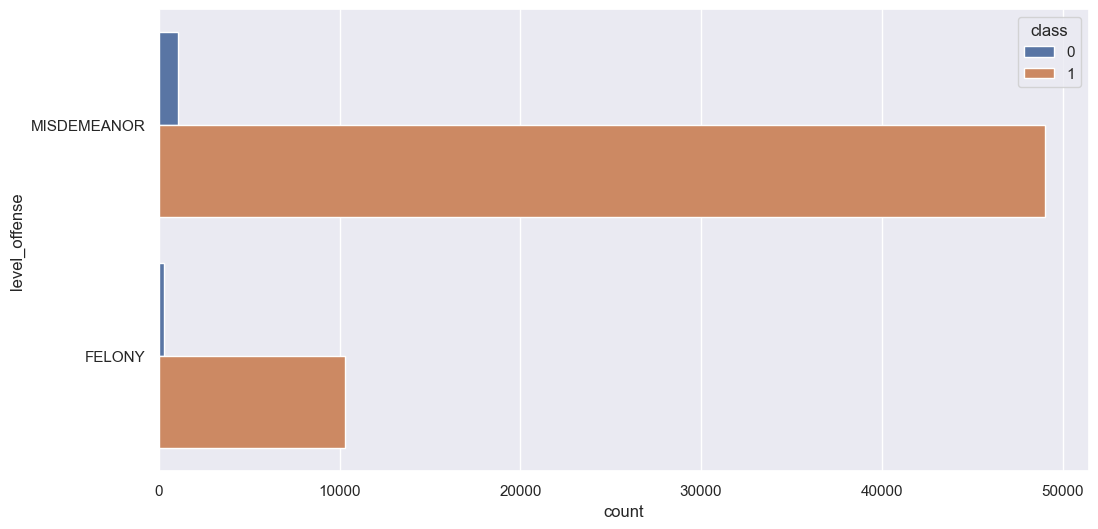

In [46]:
sns.countplot(y="level_offense", data=df3, hue='class',
              order=df3.level_offense.value_counts().iloc[:2].index)

> We need to do more than just eyeballing. Let's remember to pull out some statistics for this later.

<Axes: xlabel='count', ylabel='borough'>

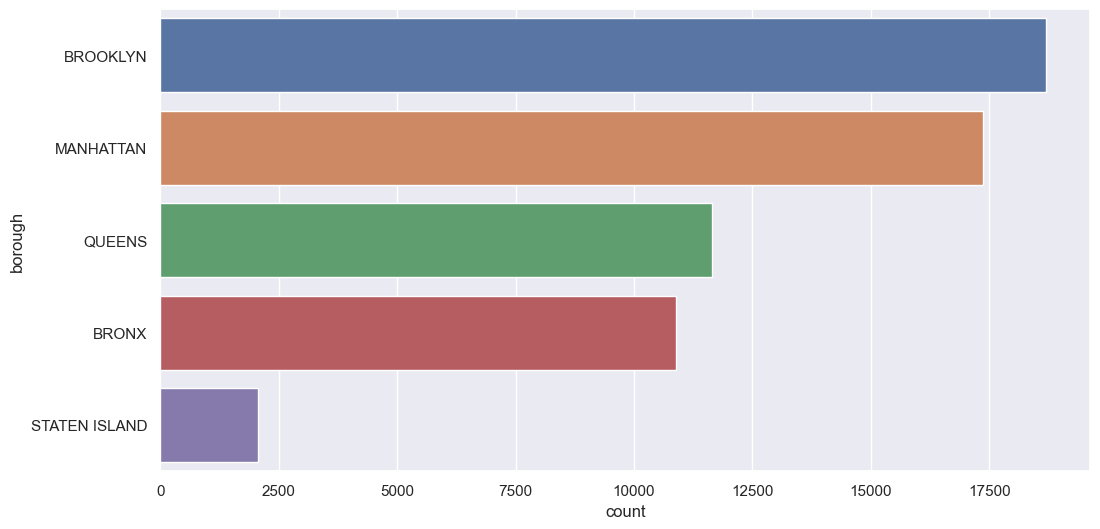

In [47]:
sns.countplot(y="borough", data=df3, 
              order=df3.borough.value_counts().iloc[:5].index)

> Brooklyn takes the top position as having the most crimes. I wonder what the ratio of crimes per capita.

<Axes: xlabel='count', ylabel='jurisdiction'>

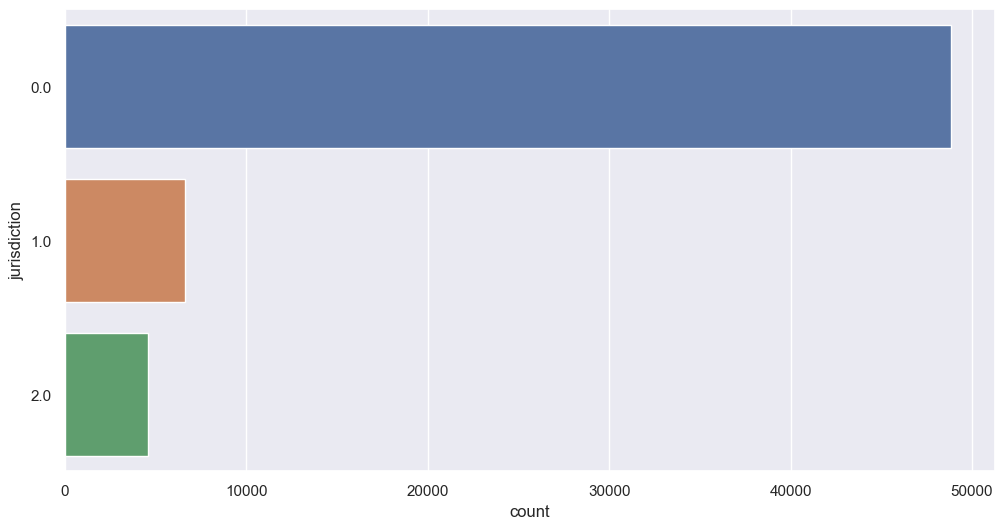

In [48]:
sns.countplot(y="jurisdiction", data=df3,
              order=df3.jurisdiction.value_counts().iloc[:3].index)

> Crimes are most likely to fall under Jurisdiction 0, 1, and 2.

<Axes: xlabel='count', ylabel='victim_age'>

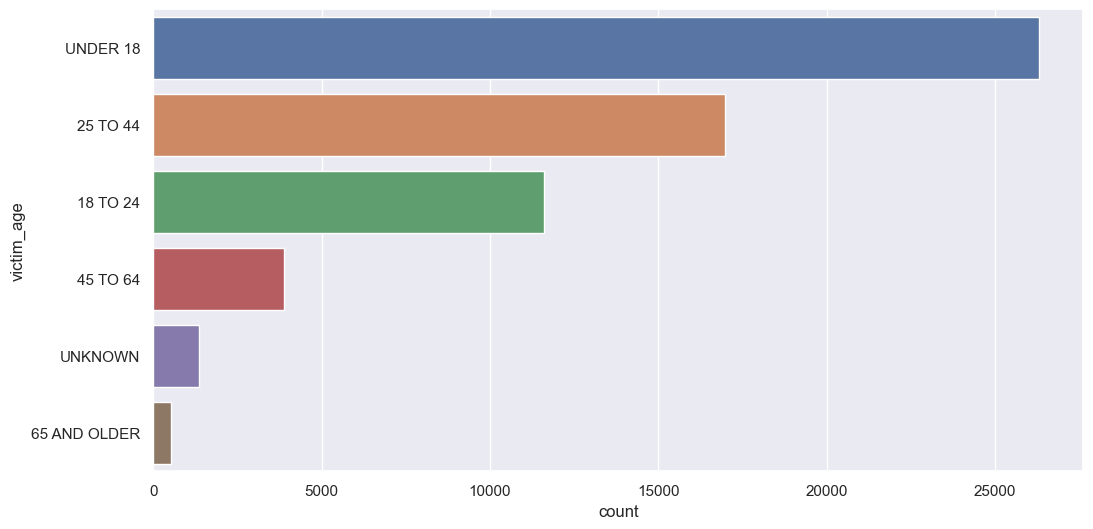

In [49]:
sns.countplot(y="victim_age", data=df3, 
              order=df3.victim_age.value_counts().iloc[:6].index)

> Those under 18 are more likely to be victims of crimes in New York City than any other age groups.

<Axes: xlabel='count', ylabel='victim_race'>

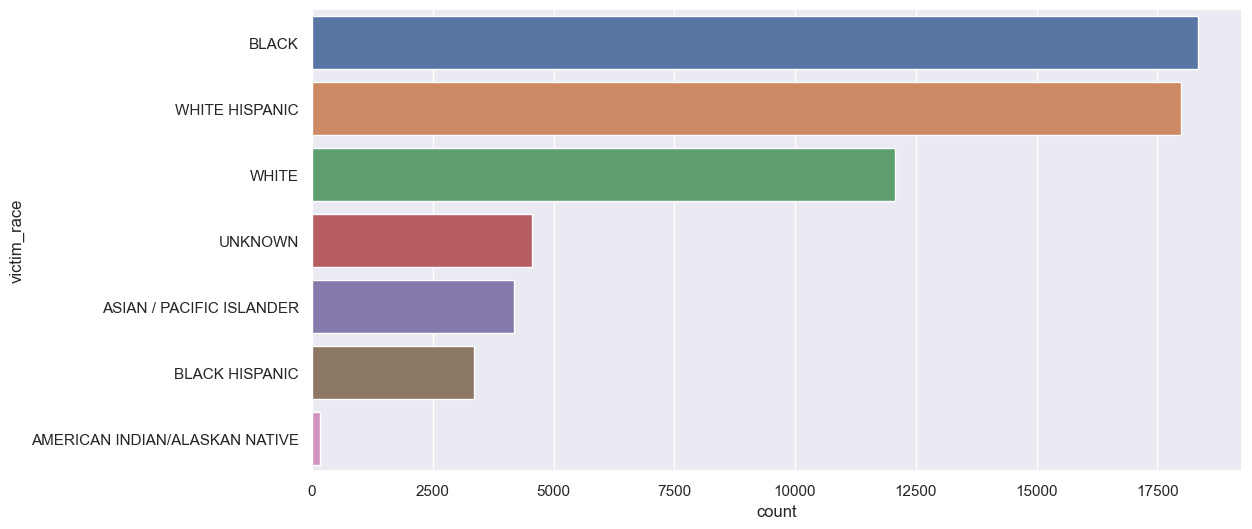

In [50]:
sns.countplot(y="victim_race", data=df3, 
              order=df3.victim_race.value_counts().iloc[:7].index)

> Black people and white hispanic people are more likely to be victimized than any other races.

<Axes: xlabel='count', ylabel='victim_sex'>

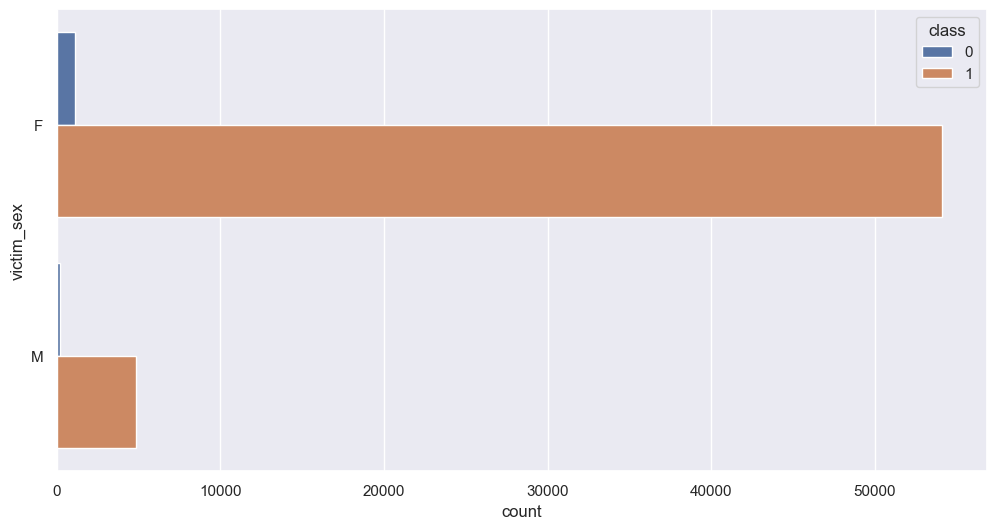

In [51]:
sns.countplot(y="victim_sex", data=df3, hue='class',
              order=df3.victim_sex.value_counts().iloc[:2].index)

> We need more statistics on this.

<Axes: xlabel='count', ylabel='weekend'>

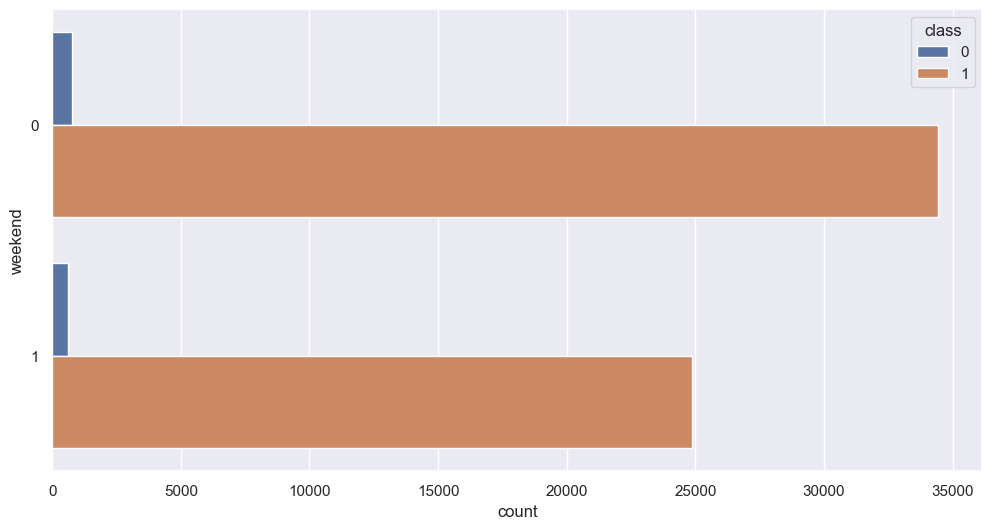

In [52]:
sns.countplot(y="weekend", data=df3, hue='class',
              order=df3.weekend.value_counts().iloc[:2].index)

> The above dispels that notion that more crimes happen on the weekend. The opposite is actually true.

In [53]:
df3.value_counts('class')

class
1    59310
0     1354
dtype: int64

In [54]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60664 entries, 0 to 62607
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   precinct               60664 non-null  object
 1   offense_code           60664 non-null  object
 2   offense_code_internal  60664 non-null  object
 3   level_offense          60664 non-null  object
 4   borough                60664 non-null  object
 5   jurisdiction           60664 non-null  object
 6   victim_age             60664 non-null  object
 7   victim_race            60664 non-null  object
 8   victim_sex             60664 non-null  object
 9   weekend                60664 non-null  int32 
 10  class                  60664 non-null  int32 
dtypes: int32(2), object(9)
memory usage: 5.1+ MB


In [55]:
df3.head()
df3.tail()
df3.shape

,precinct,offense_code,offense_code_internal,level_offense,borough,jurisdiction,victim_age,victim_race,victim_sex,weekend,class
0,79.0,233,175.0,MISDEMEANOR,BROOKLYN,0.0,18 TO 24,BLACK,F,0,1
1,30.0,233,175.0,MISDEMEANOR,MANHATTAN,0.0,18 TO 24,WHITE,F,0,1
2,120.0,233,170.0,MISDEMEANOR,STATEN ISLAND,0.0,UNDER 18,BLACK,F,0,1
3,17.0,233,175.0,MISDEMEANOR,MANHATTAN,1.0,45 TO 64,BLACK,M,1,1
4,13.0,233,175.0,MISDEMEANOR,MANHATTAN,1.0,25 TO 44,ASIAN / PACIFIC ISLANDER,F,0,1


,precinct,offense_code,offense_code_internal,level_offense,borough,jurisdiction,victim_age,victim_race,victim_sex,weekend,class
62603,77.0,233,175.0,MISDEMEANOR,BROOKLYN,0.0,UNDER 18,BLACK,F,0,1
62604,94.0,233,175.0,MISDEMEANOR,BROOKLYN,1.0,UNDER 18,BLACK,F,0,1
62605,62.0,233,175.0,MISDEMEANOR,BROOKLYN,1.0,UNDER 18,WHITE HISPANIC,F,1,1
62606,41.0,233,175.0,MISDEMEANOR,BRONX,0.0,UNKNOWN,UNKNOWN,M,0,1
62607,79.0,233,175.0,MISDEMEANOR,BROOKLYN,0.0,UNDER 18,WHITE,F,1,1


(60664, 11)

### Create Dummy Variables

> Let's do some One Hot Encoding to convert categorical values to numerical to  make them suitable for machine learning.

In [56]:
# One-Hot Encoding
ohe = pd.get_dummies(data=df2)
ohe.head()

,weekend,class,precinct_1.0,precinct_10.0,precinct_100.0,precinct_101.0,precinct_102.0,precinct_103.0,precinct_104.0,precinct_105.0,precinct_106.0,precinct_107.0,precinct_108.0,precinct_109.0,precinct_110.0,precinct_111.0,precinct_112.0,precinct_113.0,precinct_114.0,precinct_115.0,precinct_120.0,precinct_121.0,precinct_122.0,precinct_123.0,precinct_13.0,precinct_14.0,precinct_17.0,precinct_18.0,precinct_19.0,precinct_20.0,precinct_22.0,precinct_23.0,precinct_24.0,precinct_25.0,precinct_26.0,precinct_28.0,precinct_30.0,precinct_32.0,precinct_33.0,precinct_34.0,precinct_40.0,precinct_41.0,precinct_42.0,precinct_43.0,precinct_44.0,precinct_45.0,precinct_46.0,precinct_47.0,precinct_48.0,precinct_49.0,precinct_5.0,precinct_50.0,precinct_52.0,precinct_6.0,precinct_60.0,precinct_61.0,precinct_62.0,precinct_63.0,precinct_66.0,precinct_67.0,precinct_68.0,precinct_69.0,precinct_7.0,precinct_70.0,precinct_71.0,precinct_72.0,precinct_73.0,precinct_75.0,precinct_76.0,precinct_77.0,precinct_78.0,precinct_79.0,precinct_81.0,precinct_83.0,precinct_84.0,precinct_88.0,precinct_9.0,precinct_90.0,precinct_94.0,offense_code_115,offense_code_116,offense_code_126,offense_code_233,offense_code_361,offense_code_578,offense_code_internal_100.0,offense_code_internal_170.0,offense_code_internal_174.0,offense_code_internal_175.0,offense_code_internal_176.0,offense_code_internal_177.0,offense_code_internal_178.0,offense_code_internal_179.0,offense_code_internal_180.0,offense_code_internal_586.0,offense_code_internal_646.0,offense_code_internal_696.0,offense_code_internal_697.0,level_offense_FELONY,level_offense_MISDEMEANOR,borough_BRONX,borough_BROOKLYN,borough_MANHATTAN,borough_QUEENS,borough_STATEN ISLAND,jurisdiction_0.0,jurisdiction_1.0,jurisdiction_11.0,jurisdiction_12.0,jurisdiction_13.0,jurisdiction_14.0,jurisdiction_15.0,jurisdiction_2.0,jurisdiction_3.0,jurisdiction_4.0,jurisdiction_6.0,jurisdiction_69.0,jurisdiction_7.0,jurisdiction_72.0,jurisdiction_76.0,jurisdiction_88.0,jurisdiction_9.0,jurisdiction_97.0,victim_age_18 TO 24,victim_age_25 TO 44,victim_age_45 TO 64,victim_age_65 AND OLDER,victim_age_UNDER 18,victim_age_UNKNOWN,victim_race_AMERICAN INDIAN/ALASKAN NATIVE,victim_race_ASIAN / PACIFIC ISLANDER,victim_race_BLACK,victim_race_BLACK HISPANIC,victim_race_OTHER,victim_race_UNKNOWN,victim_race_WHITE,victim_race_WHITE HISPANIC,victim_sex_D,victim_sex_E,victim_sex_F,victim_sex_M
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0
3,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0


In [57]:
# Separate the independent and dependent features
X = ohe.loc[:, ohe.columns != 'class']
y = ohe.loc[:, ohe.columns == 'class']

### SMOTE

> Now it's time to split the data for training and validation.

In [58]:
os = SMOTE(random_state=493)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=493)

columns = X_train.columns

In [59]:
os_data_X, os_data_y = os.fit_resample(X_train, y_train)

os_data_X = pd.DataFrame(data = os_data_X,columns = columns )
os_data_y = pd.DataFrame(data = os_data_y,columns = ['class'])

In [60]:
# we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of no subscription in oversampled data",len(os_data_y[os_data_y['class']==0]))
print("Number of subscription",len(os_data_y[os_data_y['class']==1]))
print("Proportion of no subscription data in oversampled data is ",len(os_data_y[os_data_y['class']==0])/len(os_data_X))
print("Proportion of subscription data in oversampled data is ",len(os_data_y[os_data_y['class']==1])/len(os_data_X))

length of oversampled data is  59320
Number of no subscription in oversampled data 29660
Number of subscription 29660
Proportion of no subscription data in oversampled data is  0.5
Proportion of subscription data in oversampled data is  0.5


In [61]:
train = pd.concat([os_data_X, os_data_y], axis=1)
test = pd.concat([X_test, y_test], axis=1)

## MODELING

For this part, we'll do logistic regression and xgboost and compare the results of the two models.

#### Logistic Regression

In [62]:
logit = LogisticRegression(solver="saga", random_state=493).fit(os_data_X, os_data_y)
converge_number = logit.n_iter_ # How many iteration did it take to converge?
print('# of Iterations: ' + str(converge_number))

# TRAIN SET
train['prediction'] = logit.predict(os_data_X)
logit.predict_proba(os_data_X)
training_accuracy = logit.score(os_data_X, os_data_y) # What is the training accuracy?

# TEST SET
test['prediction'] = logit.predict(X_test)
logit.predict_proba(X_test)
test_accuracy = logit.score(X_test, y_test) # What is the testing accuracy?

print('Training: ' + str(training_accuracy))
print('Test: ' + str(test_accuracy))

# of Iterations: [84]


array([[0.10560489, 0.89439511],
       [0.07119223, 0.92880777],
       [0.00442944, 0.99557056],
       ...,
       [0.99588992, 0.00411008],
       [0.98835891, 0.01164109],
       [0.9807438 , 0.0192562 ]])

array([[0.11757781, 0.88242219],
       [0.03075845, 0.96924155],
       [0.32533628, 0.67466372],
       ...,
       [0.01331457, 0.98668543],
       [0.02450725, 0.97549275],
       [0.02633538, 0.97366462]])

Training: 0.9462744436952124
Test: 0.9560530133192667


> As shown above, the accuracy results are pretty high. I wonder if we overfitted?

In [63]:
print(classification_report(y_test, test['prediction']))

              precision    recall  f1-score   support

           0       0.05      0.05      0.05       682
           1       0.98      0.98      0.98     29650

    accuracy                           0.96     30332
   macro avg       0.51      0.51      0.51     30332
weighted avg       0.96      0.96      0.96     30332



<Figure size 1200x600 with 0 Axes>

(0.0, 1.0)

(0.0, 1.05)

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'Receiver operating characteristic')

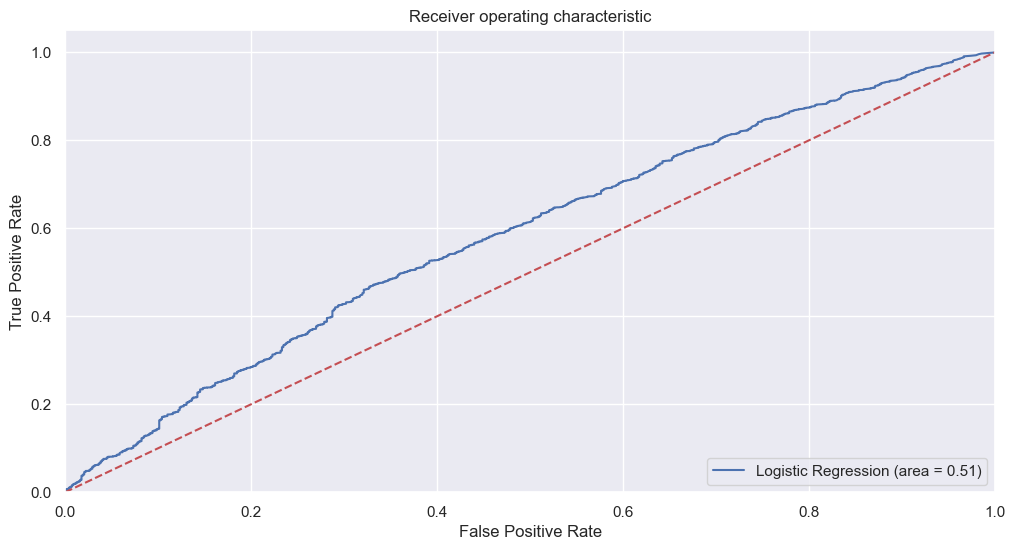

In [64]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logit.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logit.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

#### XGBoost Classifier

In [65]:
# fit model no training data
xgb = XGBClassifier()
xgb.fit(os_data_X, os_data_y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [66]:
# make predictions for train data
y_pred = xgb.predict(os_data_X)
predictions = [round(value) for value in y_pred]

# evaluate predictions on train
train_accuracy = accuracy_score(os_data_y, predictions)
print("Accuracy - Train: %.2f%%" % (train_accuracy * 100.0))

# make predictions for test data
y_pred = xgb.predict(X_test)
predictions = [round(value) for value in y_pred]

# evaluate predictions on test data
test_accuracy = accuracy_score(y_test, predictions)
print("Accuracy - Test: %.2f%%" % (test_accuracy * 100.0))

Accuracy - Train: 94.65%
Accuracy - Test: 89.89%


> As shown above, the accuracy results are still high but also lower than the accuracy from the logistic regression model. The fact that test is lower than train (but not by much) gives me confidence that we did not overfit here.
  

In [67]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.04      0.13      0.06       682
           1       0.98      0.92      0.95     29650

    accuracy                           0.90     30332
   macro avg       0.51      0.53      0.50     30332
weighted avg       0.96      0.90      0.93     30332



<Figure size 1200x600 with 0 Axes>

(0.0, 1.0)

(0.0, 1.05)

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, 'Receiver operating characteristic')

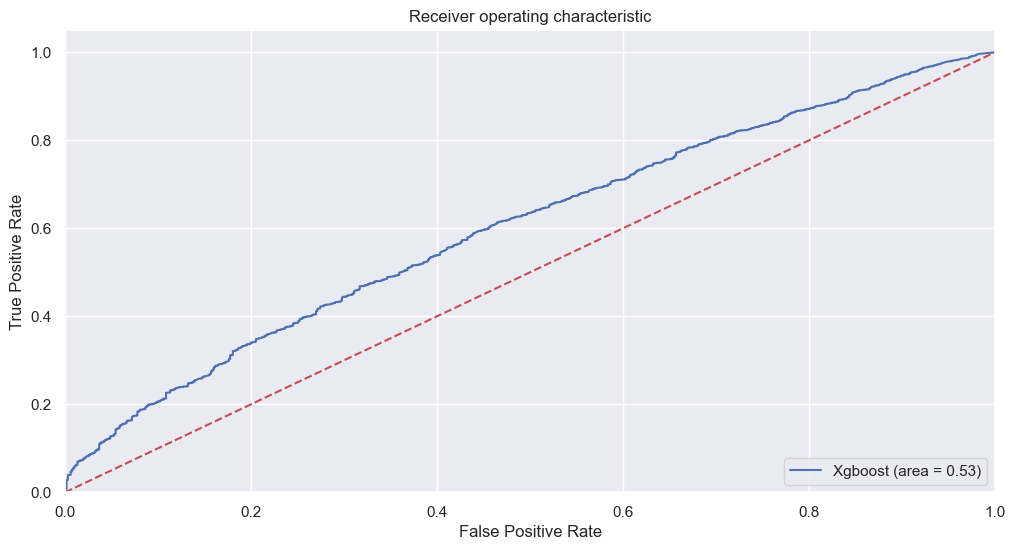

In [68]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
xgb_roc_auc = roc_auc_score(y_test, xgb.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, xgb.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Xgboost (area = %0.2f)' % xgb_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()


# CONCLUSION

Both our F1 scores suggest that our model performs pretty well but our AUC score says otherwise. When the AUC is low and F1 is high, it generally means that "your classifier currently does a decent job, however for many other values of threshold - it is pretty bad."[1] There's a lot to unpack here. So, let's address that on another post :-)

OR, better yet, let's talk about it in the responses! What do you think? Leave a comment and join the conversation!

### References

[1] https://stackoverflow.com/questions/34698161/how-to-interpret-almost-perfect-accuracy-and-auc-roc-but-zero-f1-score-precisio#:~:text=low%20AUC%20ROC%20vs%20high,threshold%20%2D%20it%20is%20pretty%20bad